In [1]:
# Подгружаем  библиотеки
from math import sqrt
from numpy import split
from numpy import array
from pandas import read_csv

import numpy as np
import tensorflow as tf
from tensorflow import keras as keras
from pandas import read_csv


from sklearn.metrics import mean_squared_error
from matplotlib import pyplot
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import RepeatVector
from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras.layers import ConvLSTM2D

c:\users\evgen\appdata\local\programs\python\python37\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
c:\users\evgen\appdata\local\programs\python\python37\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
c:\users\evgen\appdata\local\programs\python\python37\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
c:\users\evgen\appd

In [2]:
# Разделяем Датасет на тренировочную и тестовую выборки:
def split_dataset(data):
               # Разобъем на стандартные недели
               train, test = data[1:-328], data[-328:-6]
            
               print(len(train))
               # реструктуризируем  окна в еженедельные данные
               train = array(split(train, len(train)/7))
               test = array(split(test, len(test)/7))
               return train, test

In [3]:
# Загрузим исследуемый набор данных:
dataset = read_csv('household_power_consumption.txt',
                   sep=';', 
                   header=0, 
                   low_memory=False, 
                   infer_datetime_format=True,
                   parse_dates={'datetime':[0,1]},
                   index_col=['datetime'])



In [4]:
# Проверим содержимое Датасета
dataset

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
datetime,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17.0
2006-12-16 17:25:00,5.360,0.436,233.630,23.000,0.000,1.000,16.0
2006-12-16 17:26:00,5.374,0.498,233.290,23.000,0.000,2.000,17.0
2006-12-16 17:27:00,5.388,0.502,233.740,23.000,0.000,1.000,17.0
2006-12-16 17:28:00,3.666,0.528,235.680,15.800,0.000,1.000,17.0
...,...,...,...,...,...,...,...
2010-11-26 20:58:00,0.946,0.000,240.430,4.000,0.000,0.000,0.0
2010-11-26 20:59:00,0.944,0.000,240.000,4.000,0.000,0.000,0.0
2010-11-26 21:00:00,0.938,0.000,239.820,3.800,0.000,0.000,0.0


In [5]:
# Заменим значения с ? на nan
dataset.replace('?', np.NaN, inplace=True)
# Изменинм тип на Флоат32
dataset = dataset.astype('float32')


In [6]:
# Сгрупируем даты по дням
daily_groups = dataset.resample('D')
daily_data = daily_groups.sum()
# Выведем размернознось
print(daily_data.shape)
print(daily_data.head())
# Сохраним
daily_data.to_csv('household_power_consumption_days.csv')


(1442, 7)
            Global_active_power  Global_reactive_power       Voltage  \
datetime                                                               
2006-12-16          1209.176025              34.922001   93552.53125   
2006-12-17          3390.459961             226.005997  345725.31250   
2006-12-18          2203.825928             161.792007  347373.62500   
2006-12-19          1666.193970             150.942001  348479.00000   
2006-12-20          2225.748047             160.998001  348923.62500   

            Global_intensity  Sub_metering_1  Sub_metering_2  Sub_metering_3  
datetime                                                                      
2006-12-16       5180.799805             0.0           546.0          4926.0  
2006-12-17      14398.599609          2033.0          4187.0         13341.0  
2006-12-18       9247.200195          1063.0          2621.0         14018.0  
2006-12-19       7094.000000           839.0          7602.0          6197.0  
2006-12-20 

In [7]:
# Функция оценки единичного или неженедельного прогноза
def evaluate_forecasts(actual, predicted):
    scores = list()
    
    # Подсчитаем RMSE для каждого дня
    for i in range(actual.shape[1]):
        
        # Подсчитаем mse
        mse = mean_squared_error(actual[:, i], predicted[:, i])
        
        # Подсчитаем rmse
        rmse = sqrt(mse)
        
        # Запишем
        scores.append(rmse)
        
    # Подсчитаем в целом RMSE
    s = 0
    for row in range(actual.shape[0]):
        for col in range(actual.shape[1]):
            s += (actual[row, col] - predicted[row, col])**2
    score = sqrt(s / (actual.shape[0] * actual.shape[1]))
    
    # Выведем график прогнозов и наблюдений
    for j in range(predicted.shape[1]):
        show_plot(actual[:, j], predicted[:, j], j + 1)	
    return score, scores

In [8]:
# Заполним отсутствующие значения значением в то же время один день назад
def fill_missing(values):
    one_day = 60 * 24
    for row in range(values.shape[0]):
        for col in range(values.shape[1]):
           if np.isnan(values[row, col]):
               values[row, col] = values[row - one_day, col]

                
# Заполним недостающие
fill_missing(dataset.values)

# Добавим столбец для оставшейся части подметрик
values = dataset.values
dataset['sub_metering_4'] = (values[:,0] * 1000 / 60) - (values[:,4] + values[:,5] + values[:,6])

# сохраним получившийся датасет
dataset.to_csv('household_power_consumption.csv')
               
                

In [9]:
# загрузим новый датасет
dataset = read_csv('household_power_consumption.csv', 
                   header=0, 
                   infer_datetime_format=True, 
                   parse_dates=['datetime'],
                   index_col=['datetime'])

# Сгрупируем даты по дням
daily_groups = dataset.resample('D')
daily_data = daily_groups.sum()

# выведем размер и первые строки
print(daily_data.shape)
print(daily_data.head())

#  сохраним
daily_data.to_csv('household_power_consumption_days.csv')


(1442, 8)
            Global_active_power  Global_reactive_power    Voltage  \
datetime                                                            
2006-12-16             1209.176                 34.922   93552.53   
2006-12-17             3390.460                226.006  345725.32   
2006-12-18             2203.826                161.792  347373.64   
2006-12-19             1666.194                150.942  348479.01   
2006-12-20             2225.748                160.998  348923.61   

            Global_intensity  Sub_metering_1  Sub_metering_2  Sub_metering_3  \
datetime                                                                       
2006-12-16            5180.8             0.0           546.0          4926.0   
2006-12-17           14398.6          2033.0          4187.0         13341.0   
2006-12-18            9247.2          1063.0          2621.0         14018.0   
2006-12-19            7094.0           839.0          7602.0          6197.0   
2006-12-20            9313

In [10]:
# Разбиваем суточные данные на на обучающие и валидационные
def split_dataset(data):
    # разделим по неделям
    train, test = data[1:-328], data[-328:-6]
    # Разделим по дням недели
    train = array(split(train, len(train)/7))
    test = array(split(test, len(test)/7))
    return train, test


In [11]:
# Протестируем функцию разбивки данных
dataset = read_csv('household_power_consumption_days.csv',
                   header=0, 
                   infer_datetime_format=True,
                   parse_dates=['datetime'],
                   index_col=['datetime'])
train, test = split_dataset(dataset.values)
# Посмотрим на размер тренировочной выборки
print(train.shape)
print(train[0, 0, 0], train[-1, -1, 0])
# Посмотрим на размер тестовой выборки
print(test.shape)
print(test[0, 0, 0], test[-1, -1, 0])


(159, 7, 8)
3390.46 1309.2679999999998
(46, 7, 8)
2083.4539999999984 2197.006000000004


In [12]:
# Обучим и оценим модель 
def evaluate_model(train, test, n_input):
# Обучим функцию вызвав build_model
       model = build_model(train, n_input)
       # history is a list of weekly data
       history = [x for x in train]
       # walk-forward validation over each week
       predictions = list()
       for i in range(len(test)):
              # Спрогнозируем неделю
              yhat_sequence = forecast(model, history, n_input)
              # Запишем данные для прогнозирования следующей недели:
              predictions.append(yhat_sequence)
              # Обучим и оценим модель
              history.append(test[i, :])
       # Оценим прогноз по дням на каждую неделю:
       predictions = array(predictions)
       score, scores = evaluate_forecasts(test[:, :, 0], predictions)
       return score, scores



In [13]:
# выведем подсчет
def summarize_scores(name, score, scores):
    s_scores = ', '.join(['%.1f' % s for s in scores])
    print('%s: [%.3f] %s' % (name, score, s_scores))


In [14]:
# Преобразуем  историю во входы и выходы
def to_supervised(train, n_input, n_out=7):
    # Сгладим данные
       data = train.reshape((train.shape[0]*train.shape[1], train.shape[2]))
       X, y = list(), list()
       in_start = 0
       #  пошагово пройдем по всей истории
       for _ in range(len(data)):
              # определите конец входной последовательности  
              in_end = in_start + n_input
              out_end = in_end + n_out
              # убедимся что у нас достаточно данных для этого экземпляра 
              if out_end <= len(data):
                     x_input = data[in_start:in_end, 0]
                     x_input = x_input.reshape((len(x_input), 1))
                     X.append(x_input)
                     y.append(data[in_end:out_end, 0])
              # Идем на один шаг вперед
              in_start += 1
       return array(X), array(y)


In [15]:
# Функция обучения модели
def build_model(train, n_input):
    # подготовим данные
        train_x, train_y = to_supervised(train, n_input)
        # зададим параметры
        verbose, epochs, batch_size = 0, 70, 16
        n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
        # зададим модель
        model = Sequential()
        model.add(LSTM(200, activation='relu', input_shape=(n_timesteps, n_features)))
        model.add(Dense(100, activation='relu'))
        model.add(Dense(n_outputs))
        model.compile(loss='mse', optimizer='adam')
        # обучим сеть
        model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose)
        return model


In [16]:
# Сделаем прогноз
def forecast(model, history, n_input):
     # Выравним данные
     data = array(history)
     data = data.reshape((data.shape[0]*data.shape[1], data.shape[2]))
     # Извлечем последние наблюдения для входных данных
     input_x = data[-n_input:, 0]
     # Изменим размернгсть [1, n_input, 1]
     input_x = input_x.reshape((1, len(input_x), 1))
     # Спрогнозируем следующую неделю
     yhat = model.predict(input_x, verbose=0)
     # Нас интересует только прогноз
     yhat = yhat[0]
     return yhat


In [17]:
# визуализируем график
def show_plot(true, pred, title):
    fig = pyplot.subplots()
    pyplot.plot(true, label='Y_original')
    pyplot.plot(pred, dashes=[4, 3], label='Y_predicted')
    pyplot.xlabel('N_samples', fontsize=12)
    pyplot.ylabel('Instance_value', fontsize=12)
    pyplot.title(title, fontsize=12)
    pyplot.grid(True)
    pyplot.legend(loc='upper right')
    pyplot.show()


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


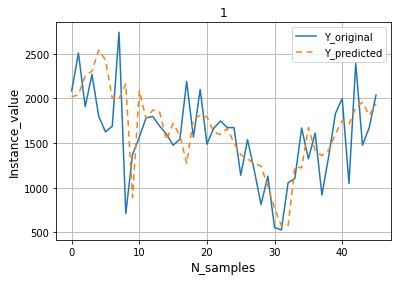

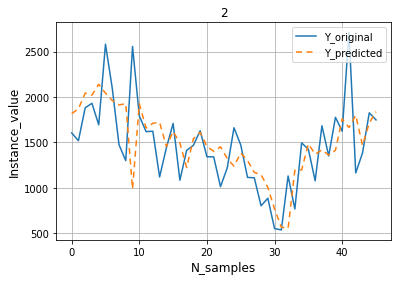

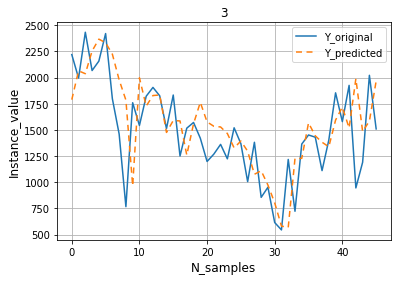

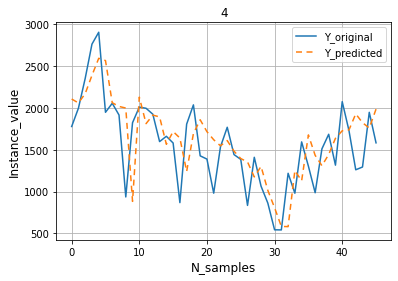

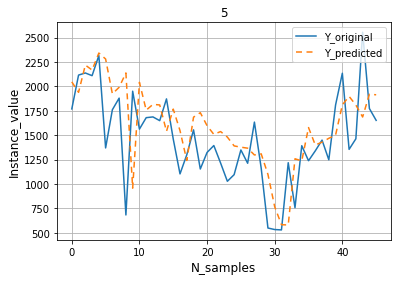

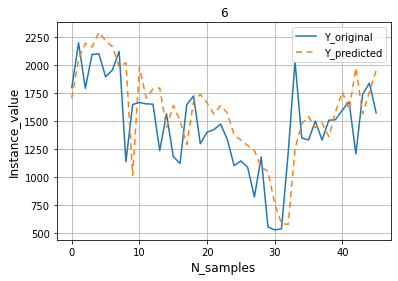

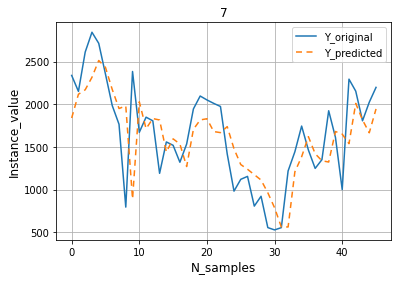

lstm: [401.722] 422.9, 402.5, 371.9, 402.7, 428.2, 344.5, 431.5


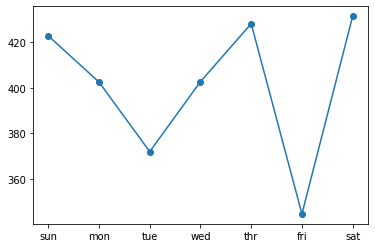

In [18]:

# Загрузим новые данные
dataset = read_csv('household_power_consumption_days.csv', 
                   header=0, 
                   infer_datetime_format=True,
                   parse_dates=['datetime'], 
                   index_col=['datetime'])
# Разделим данные на обучающие и тестовые
train, test = split_dataset(dataset.values)
# Зададим период для подсчета
n_input = 7
score, scores = evaluate_model(train, test, n_input)
# выведем параметры модели
summarize_scores('lstm', score, scores)
# выведем график расчетов
days = ['sun', 'mon', 'tue', 'wed', 'thr', 'fri', 'sat']
pyplot.plot(days, scores, marker='o', label='lstm')
pyplot.show()


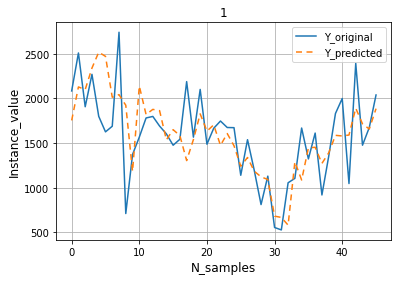

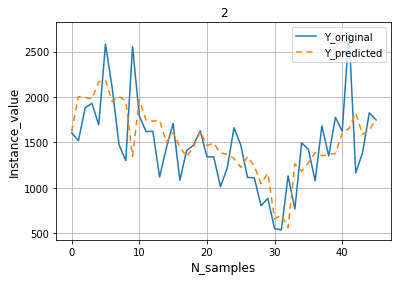

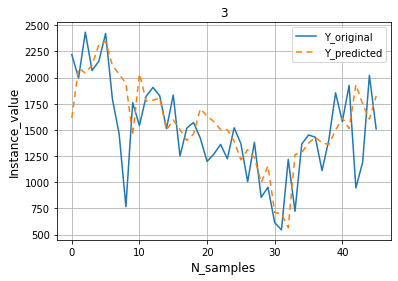

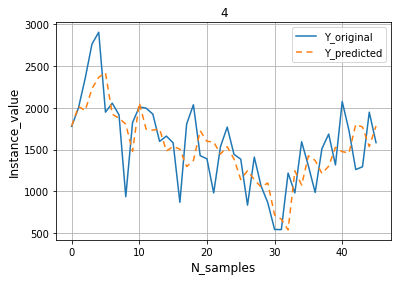

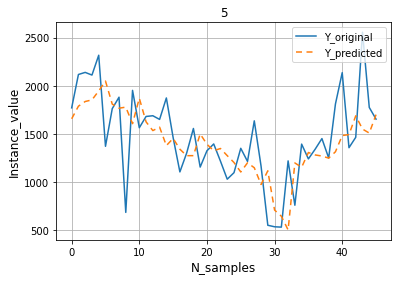

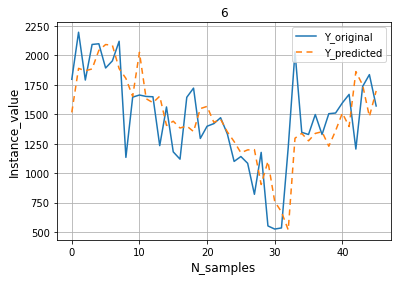

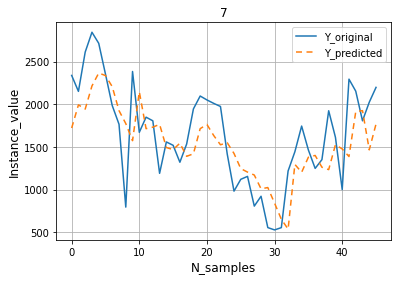

lstm: [372.809] 385.4, 383.2, 368.6, 375.3, 369.1, 294.9, 421.5


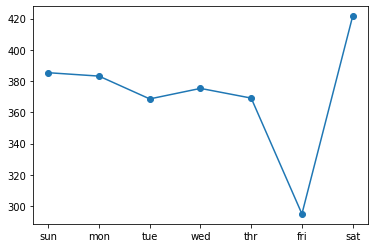

In [19]:
# Поменяем количество исследуемых дней с 7 до 14
# n_input = 14

# загрузим новый файл
dataset = read_csv('household_power_consumption_days.csv', 
                   header=0, 
                   infer_datetime_format=True,
                   parse_dates=['datetime'], 
                   index_col=['datetime'])
# разделим данные на тренировочные и тестовые
train, test = split_dataset(dataset.values)
# зададим параметры модели для расчета
n_input = 14
score, scores = evaluate_model(train, test, n_input)
# выведем параметры модели
summarize_scores('lstm', score, scores)
# выведем расчеты
days = ['sun', 'mon', 'tue', 'wed', 'thr', 'fri', 'sat']
pyplot.plot(days, scores, marker='o', label='lstm')
pyplot.show()


In [20]:
# Функция обучения модели
def build_model(train, n_input):
      # преорабазуем данные
      train_x, train_y = to_supervised(train, n_input)
      # Зададим параметры
      verbose, epochs, batch_size = 0, 20, 16
      n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
      # Зададим размерность в тестовой выборке  [samples, timesteps, features]
      train_y = train_y.reshape((train_y.shape[0], train_y.shape[1], 1))
      # Задаим модель
      model = Sequential()
      model.add(LSTM(200, activation='relu', input_shape=(n_timesteps, n_features)))
      model.add(RepeatVector(n_outputs))
      model.add(LSTM(200, activation='relu', return_sequences=True))
      model.add(TimeDistributed(Dense(100, activation='relu')))
      model.add(TimeDistributed(Dense(1)))
      model.compile(loss='mse', optimizer='adam')
      # Обучим сеть
      model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose)
      return model


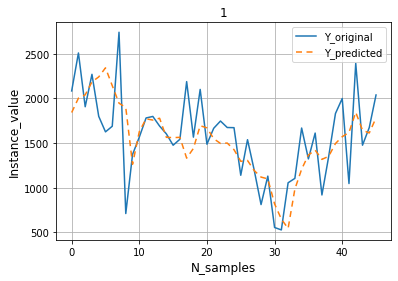

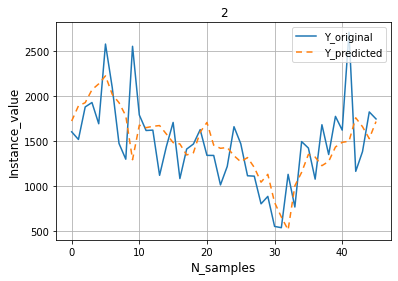

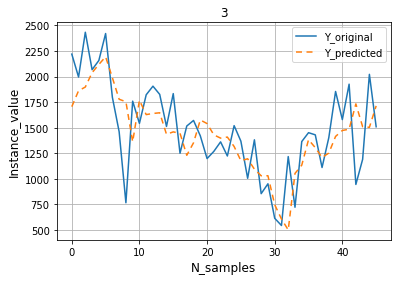

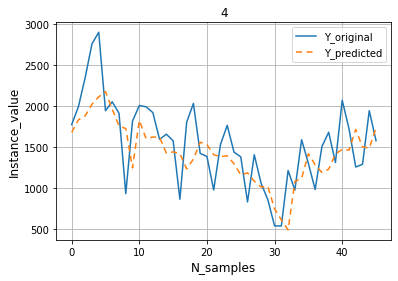

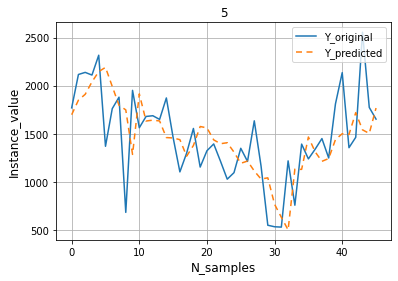

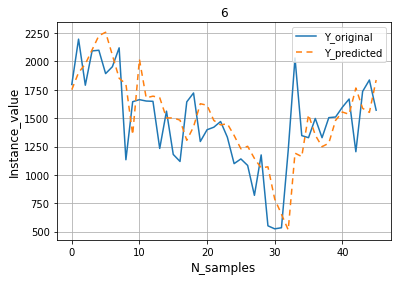

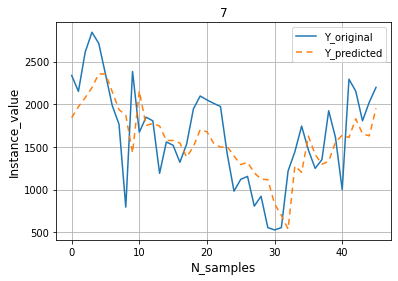

lstm: [369.204] 373.0, 385.4, 330.2, 382.7, 377.9, 304.6, 418.9


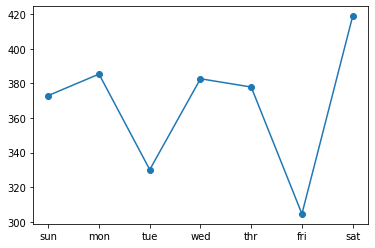

In [21]:
# Загрузим новые данные
dataset = read_csv('household_power_consumption_days.csv', 
                   header=0,
                   infer_datetime_format=True,
                   parse_dates=['datetime'],
                   index_col=['datetime'])
# Разделим данные на тренировочные и тестовые
train, test = split_dataset(dataset.values)
# Зададим новые параметры для расчетов
n_input = 14
score, scores = evaluate_model(train, test, n_input)
# выведем параметры модели
summarize_scores('lstm', score, scores)
# Выведем график расчетов
days = ['sun', 'mon', 'tue', 'wed', 'thr', 'fri', 'sat']
pyplot.plot(days, scores, marker='o', label='lstm')
pyplot.show()


In [22]:

# Добавим в функцию обучения модели слой Flatten и Conv2d
# Функция обучения модели
def build_model(train, n_steps, n_length, n_input):
         # Преобразуем данные
         train_x, train_y = to_supervised(train, n_input)
         # Зададим параметры
         verbose, epochs, batch_size = 0, 20, 16
         n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
         #  Зададим размерность в тренировочной выборке [samples, time steps, rows, cols, channels]
         train_x = train_x.reshape((train_x.shape[0], n_steps, 1, n_length, n_features))
         # Зададим размерность в тестовой выборке [samples, timesteps, features]
         train_y = train_y.reshape((train_y.shape[0], train_y.shape[1], 1))
         # Зададим параметры модели
         model = Sequential()
         model.add(ConvLSTM2D(filters=64, kernel_size=(1,3), activation='relu', input_shape=(n_steps, 1, n_length, n_features)))
         model.add(Flatten())
         model.add(RepeatVector(n_outputs))
         model.add(LSTM(200, activation='relu', return_sequences=True))
         model.add(TimeDistributed(Dense(100, activation='relu')))
         model.add(TimeDistributed(Dense(1)))
         model.compile(loss='mse', optimizer='adam')
         # Обучим сеть
         model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose)
         return model


In [23]:

# Сделаем прогноз
def forecast(model, history, n_steps, n_length, n_input):
        # Сгладим данные
        data = array(history)
        data = data.reshape((data.shape[0]*data.shape[1], data.shape[2]))
        # Извлечем последние наблюдения для входных данных
        input_x = data[-n_input:, 0]
        # Изменим размерность в  тренировочных данных [samples, time steps, rows, cols, channels]
        input_x = input_x.reshape((1, n_steps, 1, n_length, 1))
        # Спрогнозируем следующую неделю
        yhat = model.predict(input_x, verbose=0)
        # Запомним только прогноз
        yhat = yhat[0]
        return yhat


In [24]:
# Функция оценки одного или нескольких прогнозов в сравнении с ожидаемыми значениями
def evaluate_model(train, test, n_steps, n_length, n_input):
       # обучим модель
       model = build_model(train, n_steps, n_length, n_input)
       # История список еженедельных данных
       history = [x for x in train]
       # пошаговая проверка в течение каждой недели
       predictions = list()
       for i in range(len(test)):
              # Спрогнозируем неделю
              yhat_sequence = forecast(model, history, n_steps, n_length, n_input)
              # запишем результат прогноза
              predictions.append(yhat_sequence)
              # Получим реальное наблюдение и добавим в историю для прогнозирования следующей недели  
              history.append(test[i, :])
       # Сделаем прогноз по дням для каждой недели
       predictions = array(predictions)
       score, scores = evaluate_forecasts(test[:, :, 0], predictions)
       return score, scores


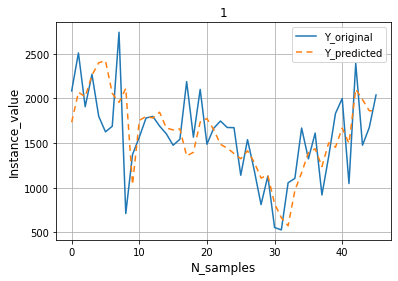

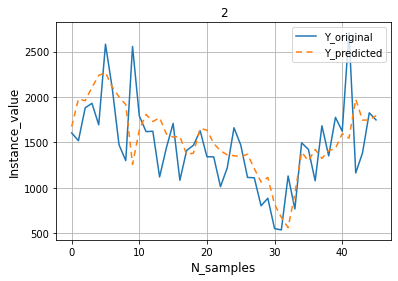

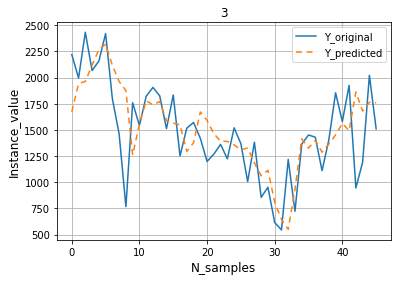

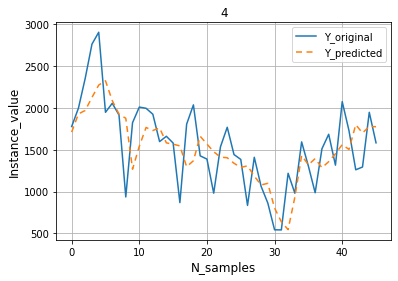

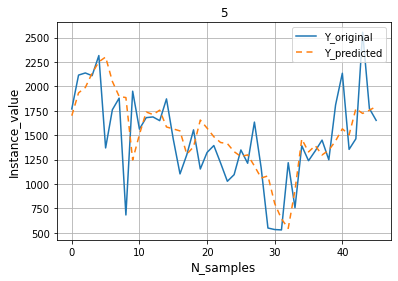

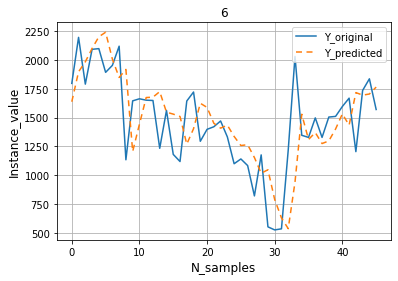

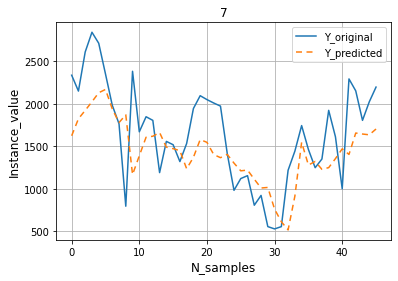

lstm: [385.256] 394.5, 400.6, 340.8, 371.9, 369.6, 324.6, 475.9


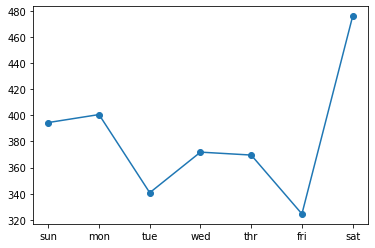

In [25]:
# Загрузим новые данные
dataset = read_csv('household_power_consumption_days.csv', header=0, infer_datetime_format=True, parse_dates=['datetime'], index_col=['datetime'])
# Разделим данные на тренировочные и тестовые
train, test = split_dataset(dataset.values)
#  Определим количество и длину последовательностей
n_steps, n_length = 2, 7
# Определим количество дней для использования как входных данных
n_input = n_length * n_steps
score, scores = evaluate_model(train, test, n_steps, n_length, n_input)
# выведем параметры модели
summarize_scores('lstm', score, scores)
# выведем график расчетов
days = ['sun', 'mon', 'tue', 'wed', 'thr', 'fri', 'sat']
pyplot.plot(days, scores, marker='o', label='lstm')
pyplot.show()


Таким образом для того чтобы получить максимальную точность при работе с временными рядами порой бывает необходимо как менять как изначальный подход, так и алгоритм, так и параметры каждого отдельно взятого алгоритма, так и группировать исходный датасет